In [1]:
from dpks.quant_matrix import QuantMatrix

/home/aaron/miniconda3/envs/DPKS/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/aaron/miniconda3/envs/DPKS/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizat

In [2]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file="../tests/input_files/design_sepsis.tsv")

In [3]:
quantified_data = (
    qm.normalize(
        method="mean",
    )
    .quantify(method="top_n")
)

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

def _generate_data_matrices(
     quantitative_data: QuantMatrix, scale: bool
) -> tuple:
    le = LabelEncoder()
    Y = le.fit_transform(quantitative_data.quantitative_data.var["group"].values)
    X = quantitative_data.quantitative_data.X.copy().transpose()
    X = np.nan_to_num(X, copy=True, nan=0.0)
    if scale:
        X = StandardScaler().fit_transform(X)
    return X, Y

scale = True
X, y = _generate_data_matrices(quantified_data, scale)

In [5]:
param_grid = {
        'min_child_weight': [0.01, 0.1, 0.5, 1, 5, 10, 25],
        'gamma': [0.1, 0.5, 1, 1.5, 2, 5, 7, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5, 6, 7,8,9,10,12,15,20],
        'max_leaves': [1, 2,3,4,5,6,7,8,9,10,15,20,25,30],
        "learning_rate": [0.0001,0.001, 0.01, 0.1, 1],
        "reg_alpha": [1e-10, 1e-7, 1e-6, 1e-5, 1e-2, 0.1, 1, 10, 15, 20,40, 60, 100],
        "reg_lambda": [1e-5, 1e-2, 0.1, 1, 5, 15, 20, 25, 100],
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 1000],
    'scale_pos_weight': [1, 3, 5, 7, 10, 15]
        }


In [6]:
from sklearn.model_selection import cross_val_score
import xgboost

clf = xgboost.XGBClassifier(

                )

In [7]:
quantified_data.classify(
    clf,
    run_param_search =True,
    verbose=True,
    param_grid=param_grid,
    param_search_method='genetic',
    threads=8,
    n_generations=2,
    pop_size=10,
    n_survive=5
)

Generation 0
Accuracy 0.8018648018648018
Best param {'min_child_weight': 0.01, 'gamma': 0.5, 'subsample': 0.7, 'colsample_bytree': 0.4, 'max_depth': 9, 'max_leaves': 4, 'learning_rate': 0.1, 'reg_alpha': 1e-10, 'reg_lambda': 20, 'n_estimators': 200, 'scale_pos_weight': 5}
Generation 1
Accuracy 0.8018648018648018
Best param {'min_child_weight': 0.01, 'gamma': 0.5, 'subsample': 0.7, 'colsample_bytree': 0.4, 'max_depth': 9, 'max_leaves': 4, 'learning_rate': 0.1, 'reg_alpha': 1e-10, 'reg_lambda': 20, 'n_estimators': 200, 'scale_pos_weight': 5}
Accuracy:  0.8018648018648018


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Axes: xlabel='generation', ylabel='scores'>

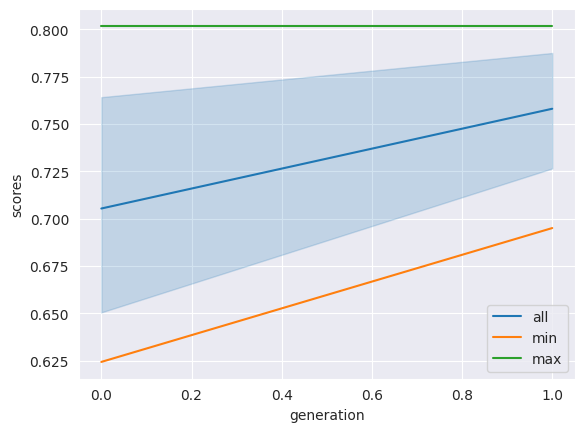

In [8]:
import pandas as pd
import seaborn as sns
populations = quantified_data.parameter_populations
plot_dict = {'generation': [], 'scores' : []}
for generation in populations.keys():
    population = populations[generation]
    for individual in population:
        score, d = individual
        plot_dict['generation'].append(generation)
        plot_dict['scores'].append(score)

plot_frame = pd.DataFrame(plot_dict)
max_frame = plot_frame.groupby('generation', as_index=False).max()
min_frame = plot_frame.groupby('generation', as_index=False).min()
sns.lineplot(data=plot_frame, x='generation', y='scores', label='all')
sns.lineplot(data=min_frame, x='generation', y='scores', label='min')
sns.lineplot(data=max_frame, x='generation', y='scores', label='max')


In [9]:
quantified_data.to_df()

,Protein,SHAP,TM_P1911_190,TM_P1911_191,TM_P1911_192,TM_P1911_193,TM_P1911_194,TM_P1911_196,TM_P1911_197,TM_M2012_010,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
0,P08603,0.002284,27.917160,26.200732,25.975755,26.515251,26.439237,26.582008,26.533406,26.131857,...,26.737434,26.750760,26.771225,26.411031,26.442979,26.512285,26.672639,26.642845,27.336391,26.863229
1,P02671,0.000000,30.908137,30.832304,30.566479,30.734064,31.100094,30.182586,29.349591,29.288924,...,30.349528,30.275675,30.712801,28.009665,29.308227,29.345303,29.498104,30.048675,30.576106,29.977439
2,P01042,0.000000,25.364128,25.234319,25.136428,25.497528,25.650704,26.249714,26.467688,26.318449,...,26.105971,26.274201,26.120931,26.173301,26.105543,26.162973,26.179120,26.049352,27.268797,26.488321
3,P00450,0.004185,27.333235,27.645029,27.405650,27.461382,27.365972,27.385601,27.124483,26.753984,...,27.483159,27.586267,27.557639,27.014641,27.331685,27.714976,27.694537,27.852459,27.574303,27.613746
4,P05156,0.000000,23.451795,23.645933,23.349888,23.595948,23.729965,24.099617,24.086203,23.422044,...,23.862439,23.755281,23.964620,23.557492,23.183517,23.507872,23.519149,23.586519,24.327400,23.881691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,P07333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.562764,...,0.000000,0.000000,0.000000,18.512752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
550,Q06323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,17.150877,18.086225,0.000000,0.000000,19.517408,0.000000,17.283127
551,P16035,0.000000,0.000000,19.124122,20.428224,19.840918,20.065922,19.232781,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
552,O95633,0.000000,0.000000,0.000000,16.563512,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.054630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
import warnings

warnings.filterwarnings(action='ignore', category=UserWarning)

from sklearn import tree

clf = xgboost.XGBClassifier()

quantified_data.rank(
    clf,
    shap_algorithm="auto",
    verbose=True,
    feature_importance_method="rfecv",
    rfe_min_features_to_select=50,
    rfe_step=25,
    threads=4,
    kfolds=3
)


Fitting initial selector.
Evaluating features below rank: 50
Model (50 features): 0.7106266749123892 0.006545042259327949
Evaluating features below rank: 51
Model (51 features): 0.7106266749123892 0.006545042259327949
Evaluating features below rank: 52
Model (52 features): 0.7106266749123892 0.006545042259327949
Evaluating features below rank: 53
Model (53 features): 0.7106266749123892 0.006545042259327949
Evaluating features below rank: 54
Model (54 features): 0.7106266749123892 0.006545042259327949
Evaluating features below rank: 55
Model (55 features): 0.7106266749123892 0.006545042259327949
Evaluating features below rank: 56
Model (56 features): 0.7106266749123892 0.006545042259327949
Evaluating features below rank: 57
Model (57 features): 0.7106266749123892 0.006545042259327949
Evaluating features below rank: 58
Model (58 features): 0.7106266749123892 0.006545042259327949
Evaluating features below rank: 59
Model (59 features): 0.7106266749123892 0.006545042259327949
Evaluating fea

In [12]:
quantified_data.to_df()


,Protein,SHAP,FeatureRank,TM_P1911_190,TM_P1911_191,TM_P1911_192,TM_P1911_193,TM_P1911_194,TM_P1911_196,TM_P1911_197,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
0,P08603,0.002284,4,27.917160,26.200732,25.975755,26.515251,26.439237,26.582008,26.533406,...,26.737434,26.750760,26.771225,26.411031,26.442979,26.512285,26.672639,26.642845,27.336391,26.863229
1,P02671,0.000000,5,30.908137,30.832304,30.566479,30.734064,31.100094,30.182586,29.349591,...,30.349528,30.275675,30.712801,28.009665,29.308227,29.345303,29.498104,30.048675,30.576106,29.977439
2,P01042,0.000000,5,25.364128,25.234319,25.136428,25.497528,25.650704,26.249714,26.467688,...,26.105971,26.274201,26.120931,26.173301,26.105543,26.162973,26.179120,26.049352,27.268797,26.488321
3,P00450,0.004185,5,27.333235,27.645029,27.405650,27.461382,27.365972,27.385601,27.124483,...,27.483159,27.586267,27.557639,27.014641,27.331685,27.714976,27.694537,27.852459,27.574303,27.613746
4,P05156,0.000000,5,23.451795,23.645933,23.349888,23.595948,23.729965,24.099617,24.086203,...,23.862439,23.755281,23.964620,23.557492,23.183517,23.507872,23.519149,23.586519,24.327400,23.881691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,P07333,0.000000,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.512752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
550,Q06323,0.000000,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,17.150877,18.086225,0.000000,0.000000,19.517408,0.000000,17.283127
551,P16035,0.000000,11,0.000000,19.124122,20.428224,19.840918,20.065922,19.232781,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
552,O95633,0.000000,11,0.000000,0.000000,16.563512,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.054630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
